In [1]:
import pandas as pd
import string
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import folium
from itertools import cycle, islice
from pandas import options
import warnings
import pickle
import re
import nltk
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import nltk


nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##This is exactly the same Notebook as the first one with tf-idf, but now I change the model and implement the ROC Curve, so I didn't analyzed again each point of this Notebook.

## *Step 1*: Load the data of preprocessing Notebook

In [3]:
x_train_file = open('/content/drive/My Drive/X_train.pkl', 'rb')
X_train = pickle.load(x_train_file)

x_test_file = open('/content/drive/My Drive/X_test.pkl', 'rb')
X_test = pickle.load(x_test_file)

y_train_file = open('/content/drive/My Drive/Y_train.pkl', 'rb')
Y_train = pickle.load(y_train_file)

y_test_file = open('/content/drive/My Drive/Y_test.pkl', 'rb')
Y_test = pickle.load(y_test_file)

x_val_file = open('/content/drive/My Drive/X_val.pkl', 'rb')
X_val = pickle.load(x_val_file)

y_val_file = open('/content/drive/My Drive/Y_val.pkl', 'rb')
Y_val = pickle.load(y_val_file)

## *Step 2*: Vectorization with TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['text'].tolist()
val = X_val['text'].to_list()
test = X_test['text'].tolist()
STOPWORDS = set(stopwords.words('english'))

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = tfidfX_val.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: (495012, 1000)
TF-IDF test shape: (2500, 1000)
TF-IDF val shape: (2488, 1000)


## *Step 3*: Convert to tensors

In [5]:
# Convert X datasets to tensors with function convert_to_tensor.
tfidfX_train = torch.tensor(tfidfX_train)
tfidfX_val = torch.tensor(tfidfX_val)
tfidfX_test = torch.tensor(tfidfX_test)

In [6]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

## *Step 4*: Use Cuda

In [7]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## *Step 5*: Built the 3rd Model

####Because I observed that the first model has better score than the second one with glove, I decide to make it much more deeper to see if it will give me better results. In lectures we learned that a deep network can fit functions better with less parameters than a shallow network. So I select to have 4 hidden layers, with each size of hidden units to be 256,128,64,32 respectively. So now I have a deeper Neural Network. I tried several combinations of numbers of hidden units, but I think this is the best option.

In [8]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim)
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 2
        self.layer_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        # Non-linearity 2
        self.relu_3 = nn.ReLU()

        # Linear function 2
        self.layer_4 = nn.Linear(hidden_dim_3, hidden_dim_4)
        # Non-linearity 2
        self.relu_4 = nn.ReLU()

        # Linear function 3 (readout)
        self.layer_5 = nn.Linear(hidden_dim_4, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)
        out = self.relu_3(out)

        out = self.layer_4(out)
        out = self.relu_4(out)

        out = self.layer_5(out)

        return torch.sigmoid(out)

## *Step 6*: Initialize the 3rd Model

As you can see I select 
- 50 epochs, learning rate 1e-4 and weight decay 1e-3. 
- For the loss function, I select the BCELoss(), because this is the best option if we have binary classification.
- As optimizer I select Adam, since I read that it has the best performance. Althouth I tried other optimizers, the score doesn't changed.


In [9]:
# Dimensions of each layer and num of epochs.
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 256
hidden_dim_2 = 128
hidden_dim_3 = 64
hidden_dim_4 = 32
output_dim = 1
num_epochs = 50

# Define our first feed forward neural network.
first_model = FeedforwardNeuralNetModel(input_dim,hidden_dim_1,hidden_dim_2,hidden_dim_3,hidden_dim_4,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=1e-4,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

## *Step 7*: Train the 3rd Model

I trained the model just like the first one, with the same batch size.


In [10]:
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

batch_size = 10000

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
    
    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()
    
    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:
    
    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)
    
    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    # print("Epoch:",epoch, "\n"
    #       "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
    #       "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

## *Step 8*: Plot loss vs epochs and accuracy vs epochs 

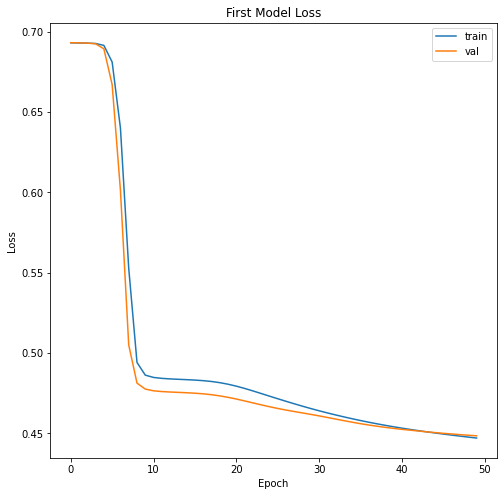

In [11]:
figure(figsize=(8,8)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

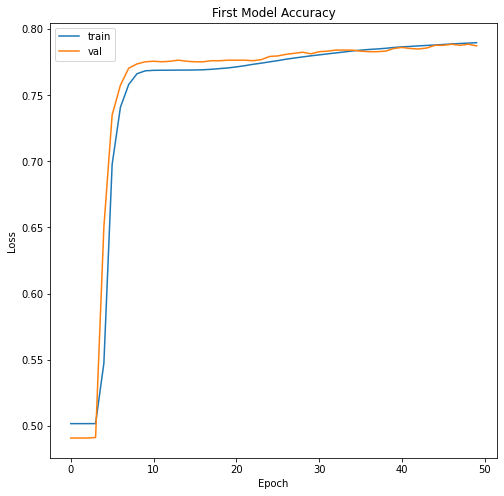

In [12]:
figure(figsize=(8,8)) 
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('First Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####As you can see there is neither **overfitting** nor **underfitting**, while the training and validation loss decreases to a point of stability with a minimal gap between the two final loss values. I noticed that if I continued with more epochs the plot of training loss continues to decrease with experience and the plot of validation loss decreases to a point and begins increasing again (which means that we have the phenomenon of overfitting). So I decide to stop to 50 epochs as we have a **good fit**.
---
####If you look carefully, you can see that the model converges approximately in epoch 40. So the **third model** needs at least 40 epochs to reach the minimun cost of 0.45. We should remember this in order to compare this with the first model.

## *Step 9*: Calculate the accuracy on test set  

In [20]:
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = first_model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

# Add each mini batch's accuracy
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7868 



In [14]:
#Show the classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      1281
         1.0       0.78      0.79      0.78      1219

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



## *Step 10*: Plot ROC Curve 

Here I plotted the roc curve from sklearn according to this source https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

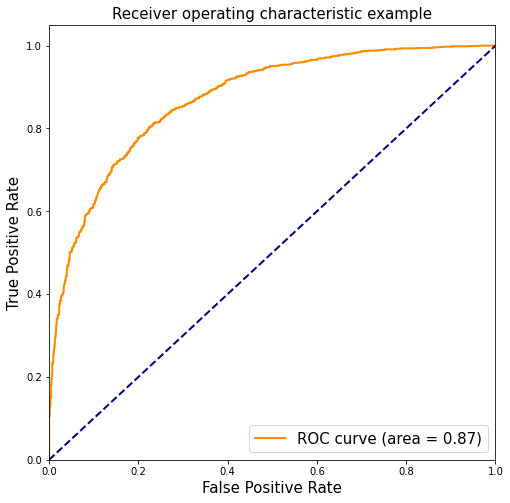

In [24]:
# Get predictions of our best model.
y_score = first_model.forward(tfidfX_test.float())

# Convert tensors to numpy arrays after we pass them to cpu.
y_score = y_score.cpu().detach().numpy()
y = Y_test.cpu().detach().numpy()

# Label binarization and store num of classes.
y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic example',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()


####**Roc Curve** tells us how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis. From theory of Machine Learning Lectures, we learned that false positive fraction = FP/(FP+TN) and true positive fraction = TP/(TP+FN). We notice that AUC is 0.87, which means there is 87% chance that model will be able to distinguish between positive and negative class. We understand that this is a very good score!

In [15]:
#Close the pickle files.
x_train_file.close()
y_train_file.close()
x_test_file.close()
y_test_file.close()
x_val_file.close()
y_val_file.close()

  ## *Step 10*: Summaries

- As you can see I picked this model as the best one.

- We notice that the third model gives score of 0.79 just like the first one. In order to reach to this score, without overfitting or underfitting, it needed at least 40 epochs to reach the minimun cost of 0.45.

- I would like to refer that I experimented with several values of hidden layers and units and I end up to 4 hidden layers. I select the number of hidden units to be ^2 to have better memory managment.

- Also I experimented with the number of units of output layer and other activation functions (like softmax or tanh), but I think that for binary classification the sigmoid fuction for output layer with one hidden unit it's the best option. For other hidden units I preffered the Relu activation function because it's the most used activation function, as we learned in the lectures and it give me the best result against to ie Selu.

- I choose this model as the best because it has the same exactly score as the first one but with less epochs. Specifically, in the first non deep model we reach the minimun cost of 0.45 in at least 120 epochs, but now we reach the minimun cost of 0.45 in only 40 epochs! This is a big improvement and verifies the theory that deeper networks is better than the swallow ones in most of cases. 

- I have to mention that the input of dataset is exactly the same as the first model so as the comparison between them to be fair enough.

- In Logistic Regression of first assignment I reached the score of 0.82, but with the whole dataset, with no max features and with bigrams. So if I wanted to compare the two models, I run the first assignment with the half of our dataset, max_features=1000 in tf-idf and without any bigrams. The result that gave me this time is a score of 0.76. This means that my model (in the same data) went much better.

- Logistic regression is a technique that can be used for binary classification making a prediction when the thing to predict can be one of just two possible values. On the other side, a neural network is more complex than logistic regression. Logistic regression is a subset of a neural network classifier. For example, you can simulate a logistic regression model using a neural network with one hidden node with the identity activation function, and one output node with zero bias and logistic sigmoid activation. Therefore, **theoretically**, a neural network is always better than logistic regression, or more precisely, a neural network can do no worse than logistic regression (in most of cases). However, **in practice**, a neural network model for binary classification can be worse than a logistic regression model because neural networks are more difficult to train and are more prone to overfitting than logistic regression. This may be the reason that the score of Logistic Regression and mine 3rd model haven't so much difference. 